<h1>Wine Quality Data Science Project</h1>

<b>Data Analytics</b>

Importing python libraries and modules

In [1]:
! pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Notebooks properties for better display

#allow multiple outputs from a single code of chunk
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Data analysis
import numpy as np
import pandas as pd


### Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-notebook')

#inline plotting
%matplotlib inline

### Machine Learning

## Feature engineering
#outliers
from feature_engine.outliers import Winsorizer
#scaling numeric features
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#categorical features
from feature_engine.encoding import OneHotEncoder
#skewness
from feature_engine.transformation import YeoJohnsonTransformer
#sklearn wrapper
from feature_engine.wrappers import SklearnTransformerWrapper
#feature selection
from feature_engine.selection import DropCorrelatedFeatures,DropDuplicateFeatures

##pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

##Models
from sklearn.linear_model import LinearRegression

##Cross validation and data resampling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

##model evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_error
from yellowbrick.regressor import PredictionError,ResidualsPlot




In [3]:
#Viewing dataset
df = pd.read_csv('/content/wine_quality.csv')
print('Data contains {} columns and {} rows'.format(df.shape[1], df.shape[0]))
df.head()

Data contains 9 columns and 1658 rows


,quality_score,wine_type,alcohol,citric_acid,density,ph,residual_sugar,total_sulfur_dioxide,fixed_acidity
0,7.06,white,12.9,0.26,0.99080,3.08,9.7,102.0,6.2
1,4.27,white,9.5,0.09,0.99566,2.93,10.9,131.0,6.6
2,6.35,white,9.6,0.23,0.99450,3.34,6.2,117.0,6.7
3,7.08,white,13.4,0.24,0.98934,3.04,6.1,86.0,6.2
4,5.75,white,9.5,0.24,0.99420,2.99,3.6,85.0,6.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1658 entries, 0 to 1657
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   quality_score         1658 non-null   float64
 1   wine_type             1658 non-null   object 
 2   alcohol               1658 non-null   float64
 3   citric_acid           1658 non-null   float64
 4   density               1658 non-null   float64
 5   ph                    1658 non-null   float64
 6   residual_sugar        1658 non-null   float64
 7   total_sulfur_dioxide  1658 non-null   float64
 8   fixed_acidity         1658 non-null   float64
dtypes: float64(8), object(1)
memory usage: 116.7+ KB


In [5]:
df.isnull().sum()

quality_score           0
wine_type               0
alcohol                 0
citric_acid             0
density                 0
ph                      0
residual_sugar          0
total_sulfur_dioxide    0
fixed_acidity           0
dtype: int64

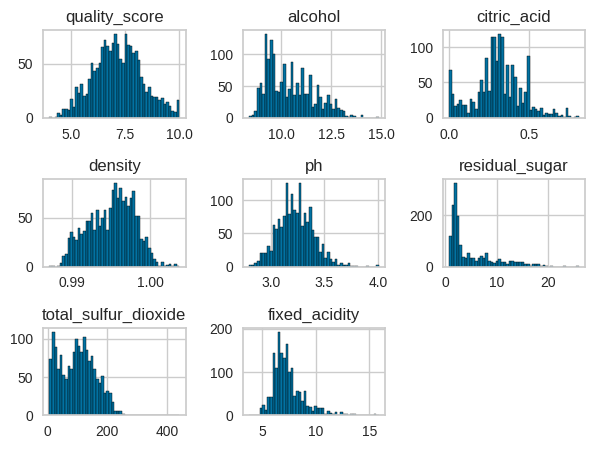

In [6]:
#checking how the numeric features are distributed in the dataset
df.hist(figsize=(7,5),bins=50,edgecolor='black')
plt.subplots_adjust(hspace=0.7,wspace=0.4);

From the above diagrams :


It can be seen that most of the data is skewed and not normally distributted


with such data fed into the model it will affect model performance and prediction.

Changes need to be made on this dataset to make it perfect for the model to understand  the features and how it affects the wine quality


In [7]:
#exploring the data
df.describe().round(2)

,quality_score,alcohol,citric_acid,density,ph,residual_sugar,total_sulfur_dioxide,fixed_acidity
count,1658.00,1658.00,1658.00,1658.00,1658.00,1658.00,1658.00,1658.00
mean,7.16,10.47,0.31,1.00,3.23,4.96,102.12,7.41
std,1.12,1.17,0.15,0.00,0.17,4.52,58.58,1.46
min,4.00,8.40,0.00,0.99,2.80,0.70,6.00,3.80
25%,6.41,9.50,0.23,0.99,3.12,1.80,50.00,6.50
50%,7.13,10.30,0.31,1.00,3.23,2.60,103.00,7.10
75%,7.92,11.30,0.40,1.00,3.34,7.20,144.00,8.00
max,10.00,14.90,0.81,1.00,4.01,26.05,440.00,15.90


From the above table features like ['total_sulfur_dioxide','density'] clearly shows some skewness and outliers in the data

<Figure size 500x300 with 0 Axes>

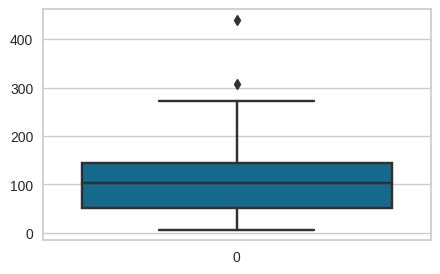

In [8]:
plt.figure(figsize=(5,3))
ax = sns.boxplot(df['total_sulfur_dioxide'])

Assumptions concerning some outliers in total_sulfur_dioxide column  confirmed.

There might be other columns with same and similar problem .

Feature engineering need to be performed to make changes to the data because the model i will be using considers outliers as threat to model performance

And outliers can make the regression lines less accurate in predicting other data.



<h2>Feature Engineering</h3>

### Data Resampling

During the data processing step, we must always split our original data into training and test sets **before** feature engineering.

This guards against [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)), where information in the training data leaks into the test data via transformations (such as scaling numeric variables - more on this below)


In [9]:
#splitting of datasets to train and test
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['quality_score']),  #drop the quality score column
    df['quality_score'],
    train_size=0.8,
    random_state=42,
)

In [10]:
X_train.head()


,wine_type,alcohol,citric_acid,density,ph,residual_sugar,total_sulfur_dioxide,fixed_acidity
1468,red,10.2,0.08,0.99484,3.50,1.9,31.0,5.4
741,white,12.2,0.22,0.99076,2.97,4.5,73.0,7.2
585,white,9.8,0.31,0.99420,3.41,5.2,120.0,6.8
1305,white,9.7,0.24,0.99560,3.21,6.0,77.0,7.1
306,white,9.7,0.69,0.99310,3.06,1.3,171.0,6.8


 I will be creating a list containing numeric features and categorical features.

 This will allow feature engineering process to be done accordingly

In [11]:
#creating list for numeric features
numeric_features = (
    X_train
    .select_dtypes('number')
    .columns
    .to_list()

)

#list for categorical features
categorical_features =(
    X_train
    .select_dtypes('object')
    .columns
    .to_list()
)


In [12]:
# Display our outputs
print('Categorical features:  ', categorical_features)
print('Numeric features:      ', numeric_features)

Categorical features:   ['wine_type']
Numeric features:       ['alcohol', 'citric_acid', 'density', 'ph', 'residual_sugar', 'total_sulfur_dioxide', 'fixed_acidity']


### Feature egineering pipelines for our data

Building a pipeline that processes our numeric features in the wine data with the following steps:

- Remove skewness with Yeo-Johnson
- Standardize the data
- Cap outliers with the IQR method
- Remove correlated features



<Figure size 600x400 with 0 Axes>

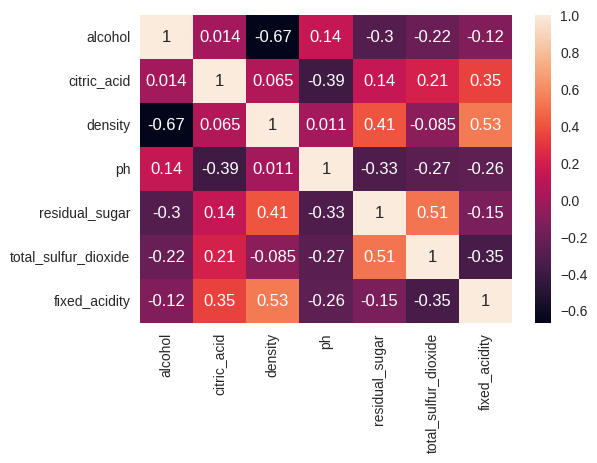

In [13]:
#Checking if there is multicollinearity among the features
plt.figure(figsize=(6,4))
ax = sns.heatmap(X_train[numeric_features].corr(),annot=True)

In [14]:
#numeric pipeline
numeric_pipeline = Pipeline(
    [
        ('skewness',YeoJohnsonTransformer()),
        ('remove_outliers', Winsorizer(capping_method='iqr',tail='both', fold=1.5)),
        ('scaling',StandardScaler()),
        ('remove_corr', DropCorrelatedFeatures(threshold=0.6)),


    ]
)

#categorical pipeline
categorical_pipeline = Pipeline(
    [
    ('dummy encoding',OneHotEncoder(drop_last=True))
    ]
)


In [15]:
numeric_pipeline.fit(X_train[numeric_features])

Pipeline(steps=[('skewness', YeoJohnsonTransformer()),
                ('remove_outliers',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both')),
                ('scaling', StandardScaler()),
                ('remove_corr', DropCorrelatedFeatures(threshold=0.6))])

In [16]:
# Let's test our pipeline on the training data using fit_transform
categorical_pipeline.fit_transform(X_train[categorical_features])

,wine_type_red
1468,1
741,0
585,0
1305,0
306,0
...,...
1130,1
1294,1
860,1
1459,1


In [17]:
#apply all pipeline
feature_eng_pipeline = ColumnTransformer(
    [
        ('numeric_eng', numeric_pipeline, numeric_features),
        ('categorical_eng', categorical_pipeline, categorical_features)
    ],
    verbose_feature_names_out=False
)

In [18]:
# Train the pipeline
feature_eng_pipeline.fit(X_train)

ColumnTransformer(transformers=[('numeric_eng',
                                 Pipeline(steps=[('skewness',
                                                  YeoJohnsonTransformer()),
                                                 ('remove_outliers',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5,
                                                             tail='both')),
                                                 ('scaling', StandardScaler()),
                                                 ('remove_corr',
                                                  DropCorrelatedFeatures(threshold=0.6))]),
                                 ['alcohol', 'citric_acid', 'density', 'ph',
                                  'residual_sugar', 'total_sulfur_dioxide',
                                  'fixed_acidity']),
                                ('categorical_eng',
                                 Pipeline(steps=[('dummy encoding',
                                                  OneHotEncoder(drop_last=True))]),
                                 ['wine_type'])],
                  verbose_feature_names_out=False)

In [19]:
X_train_pipeline = pd.DataFrame(
    data=feature_eng_pipeline.transform(X_train), # transformed numpy array result
    columns=feature_eng_pipeline.get_feature_names_out() # column names
)

X_train_pipeline.round(2)

,alcohol,citric_acid,ph,residual_sugar,total_sulfur_dioxide,fixed_acidity,wine_type_red
0,-0.10,-1.56,1.55,-0.71,-1.29,-1.95,1.0
1,1.38,-0.59,-1.76,0.49,-0.40,0.03,0.0
2,-0.51,0.02,1.07,0.66,0.40,-0.32,0.0
3,-0.62,-0.45,-0.10,0.82,-0.32,-0.05,0.0
4,-0.62,2.32,-1.10,-1.29,1.13,-0.32,0.0
...,...,...,...,...,...,...,...
1321,-0.30,-1.28,1.60,-0.24,-1.37,0.82,1.0
1322,0.44,2.28,-0.29,-0.04,-1.31,2.40,1.0
1323,-0.85,-1.35,0.51,-0.14,-0.98,1.28,1.0
1324,-0.30,0.09,0.45,-0.56,-0.77,0.11,1.0


We can see that the density column has been dropped

after fitting our pipeline .

Data is looking good

In [20]:
X_train_pipeline.describe().round(2)

,alcohol,citric_acid,ph,residual_sugar,total_sulfur_dioxide,fixed_acidity,wine_type_red
count,1326.00,1326.00,1326.00,1326.00,1326.00,1326.00,1326.00
mean,0.00,-0.00,0.00,0.00,0.00,-0.00,0.38
std,1.00,1.00,1.00,1.00,1.00,1.00,0.49
min,-2.45,-2.14,-2.78,-2.20,-1.99,-2.47,0.00
25%,-0.85,-0.52,-0.67,-0.79,-0.85,-0.61,0.00
50%,-0.00,0.02,0.03,-0.30,0.14,-0.05,0.00
75%,0.81,0.62,0.74,0.99,0.75,0.63,1.00
max,2.48,2.32,2.85,1.91,3.15,2.49,1.00


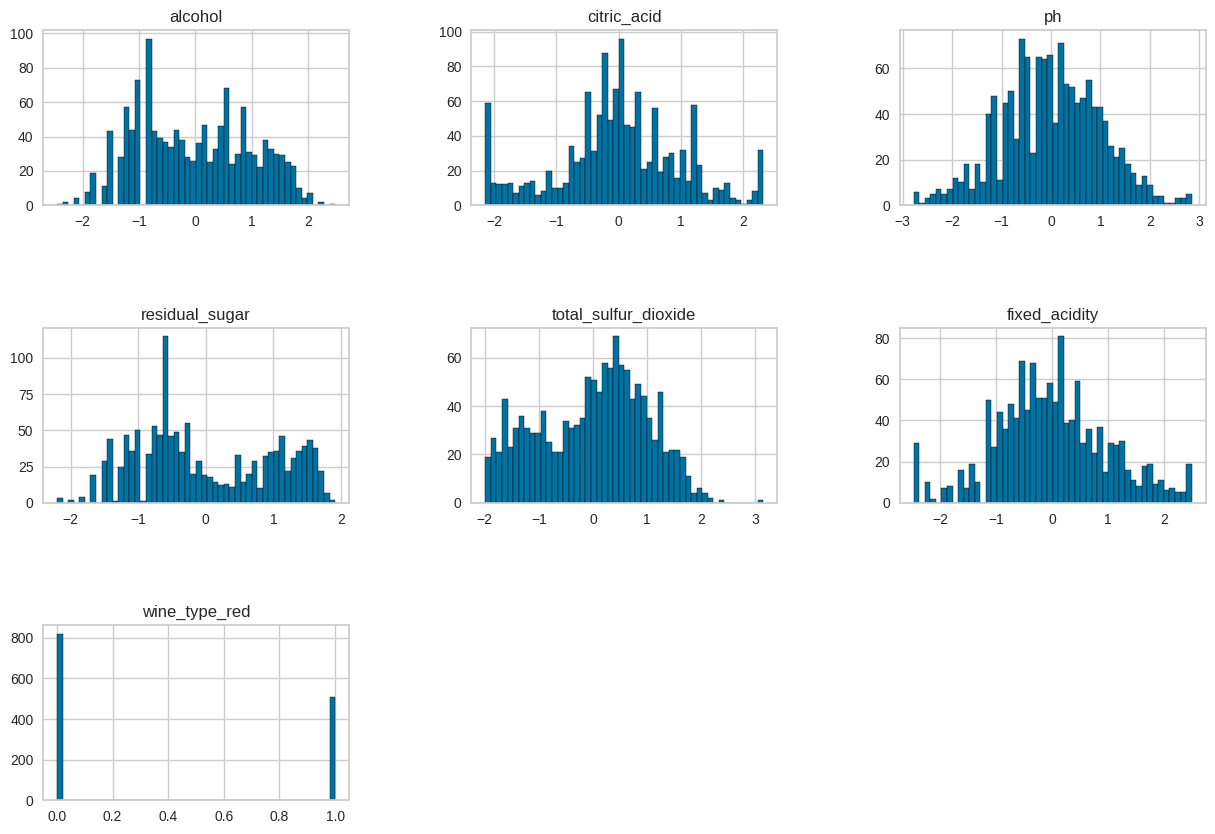

In [21]:
X_train_pipeline.hist(figsize=(15,10),bins=50,edgecolor = 'black')
plt.subplots_adjust(hspace=0.7,wspace=0.4);

<Figure size 300x500 with 0 Axes>

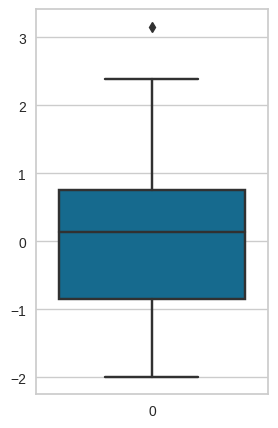

In [22]:
plt.figure(figsize=(3,5))
ax = sns.boxplot(X_train_pipeline['total_sulfur_dioxide'])

## Pipeline + Model

In [23]:
#adding models to pipeline
linear_reg_workflow = Pipeline(
    [
        ('feature_engineering', feature_eng_pipeline),
        ('linear_regression', LinearRegression()),

    ]
)




- Training the feature engineering steps
- Transforming the data
- Training the model on the transformed data

In [24]:
# A lot going on behind the scenes here!
linear_reg_workflow.fit(X_train, y_train)


Pipeline(steps=[('feature_engineering',
                 ColumnTransformer(transformers=[('numeric_eng',
                                                  Pipeline(steps=[('skewness',
                                                                   YeoJohnsonTransformer()),
                                                                  ('remove_outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5,
                                                                              tail='both')),
                                                                  ('scaling',
                                                                   StandardScaler()),
                                                                  ('remove_corr',
                                                                   DropCorrelatedFeatures(threshold=0.6))]),
                                                  ['alcohol', 'citric_acid',
                                                   'density', 'ph',
                                                   'residual_sugar',
                                                   'total_sulfur_dioxide',
                                                   'fixed_acidity']),
                                                 ('categorical_eng',
                                                  Pipeline(steps=[('dummy '
                                                                   'encoding',
                                                                   OneHotEncoder(drop_last=True))]),
                                                  ['wine_type'])],
                                   verbose_feature_names_out=False)),
                ('linear_regression', LinearRegression())])

In [25]:
# Now we can use our workflow to get predictions
train_predict= linear_reg_workflow.predict(X_train)

## Model Evaluation and performance

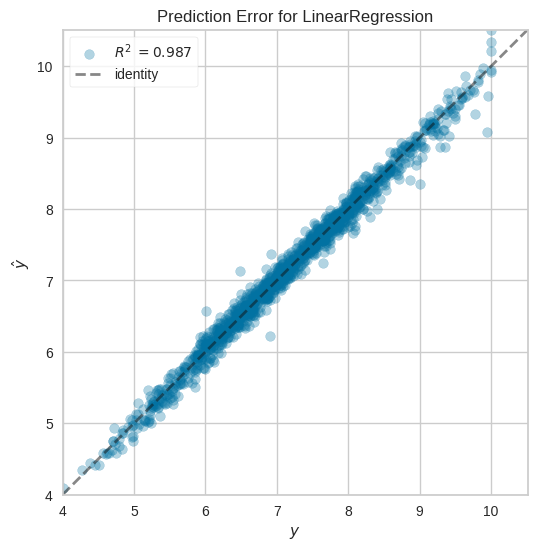

In [26]:
# Expand the plot size
plt.figure(figsize=(6,8))

# Create Prediction Error Plot
linear_wf_train_error = PredictionError(linear_reg_workflow, is_fitted=True, bestfit=False, alpha=0.3)

linear_wf_train_error.score(X_train, y_train)

linear_wf_train_error.show();

In [27]:
mean_squared_error(y_train,train_predict,squared=False)

0.12357037181356899

Its performing well on our training data

We gotta check it on our test data to see how its performing

In [28]:
mean_absolute_error(y_train,train_predict)

0.09165338632876188

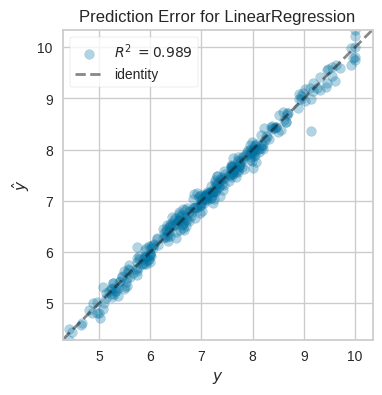

In [29]:
# Expand the plot size
plt.figure(figsize=(4,6))

# Create Prediction Error Plot
linear_wf_test_error = PredictionError(linear_reg_workflow, is_fitted=True, bestfit=False, alpha=0.3)

linear_wf_test_error.score(X_test, y_test)

linear_wf_test_error.show();

Wow ,It generalizes well on our test data too

I will love to use cross validation to double check the performance of the model and process

## Cross Validation

In [30]:
#checking for training data
workflow_cv_scores = cross_val_score(linear_reg_workflow,X_train,y_train,cv=10)
print(workflow_cv_scores)
print('the average score is ',workflow_cv_scores.mean().round(3))


[0.98860556 0.98690729 0.98560096 0.98888844 0.98511922 0.98035953
 0.99033038 0.98835624 0.98544357 0.98548006]
the average score is  0.987


In [31]:
#checking for test data
sec_workflow_cv_scores = cross_val_score(linear_reg_workflow,X_test,y_test,cv=10)
print(sec_workflow_cv_scores)
print('The average score is ',sec_workflow_cv_scores.mean().round(3))

[0.98266713 0.98952811 0.9911536  0.98655115 0.99290163 0.98610607
 0.98816054 0.99239313 0.99188959 0.98917132]
The average score is  0.989


In [32]:
import statsmodels.formula.api as smf

In [33]:
df.columns

Index(['quality_score', 'wine_type', 'alcohol', 'citric_acid', 'density', 'ph',
       'residual_sugar', 'total_sulfur_dioxide', 'fixed_acidity'],
      dtype='object')

In [34]:
formula = "quality_score ~ wine_type + alcohol + citric_acid + density + ph + residual_sugar + total_sulfur_dioxide + fixed_acidity"


In [35]:
model = smf.ols(formula=formula, data=df).fit()


In [36]:
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          quality_score   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     6243.
Date:                Sun, 18 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:32:45   Log-Likelihood:                 308.00
No. Observations:                1658   AIC:                            -598.0
Df Residuals:                    1649   BIC:                            -549.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -72.9767 